In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from keras.layers import Input,Embedding,Flatten,Dense,Dot,Concatenate,Dropout
from keras.models import Model,load_model
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
import os
currdir = os.getcwd()

In [3]:
os.listdir(currdir)

['.ipynb_checkpoints',
 'books.csv',
 'BooksRecommendationModel.ipynb',
 'book_tags.csv',
 'DataExploration.ipynb',
 'dot_product_model.h5',
 'nn1_model.h5',
 'nn2_model.h5',
 'ratings.csv',
 'sample_book.xml',
 'tags.csv',
 'to_read.csv']

In [4]:
ratings = pd.read_csv('ratings.csv')

In [5]:
ratings

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4
...,...,...,...
981751,10000,48386,5
981752,10000,49007,4
981753,10000,49383,5
981754,10000,50124,5


In [6]:
n_users = len(ratings.user_id.unique())
n_books = len(ratings.book_id.unique())

In [7]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [8]:
train , validate , test = train_validate_test_split(ratings)

In [9]:
train

,book_id,user_id,rating
536497,5383,11379,4
121923,1220,11208,3
126551,1266,31503,5
951547,9672,43866,4
418145,4188,28883,4
...,...,...,...
88455,885,21658,3
933978,9484,25590,2
630407,6332,10769,3
881872,8926,45961,5


In [10]:
validate

,book_id,user_id,rating
522216,5238,39548,3
901937,9140,8809,5
156837,1569,33207,4
859697,8695,21612,4
681747,6854,43358,4
...,...,...,...
68316,684,18090,5
588606,5909,49846,5
345503,3459,33993,5
399348,3999,45126,1


In [11]:
test

,book_id,user_id,rating
870219,8805,2916,5
205546,2057,29995,5
244262,2445,10353,5
606838,6094,6724,3
185697,1858,12145,4
...,...,...,...
773452,7795,18654,4
248381,2486,19313,4
536107,5379,18298,5
398380,3990,9751,2


In [12]:
## creating word embeddings
book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books+1, 5, name="Book-Embedding")(book_input)
book_vec = Flatten(name="Flatten-Books")(book_embedding)

user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

In [13]:
### simple dot product model or the content based recommender model

prod = Dot(name="Dot-Product", axes=1)([book_vec, user_vec])
model = Model([user_input, book_input], prod)

model.compile(optimizer = 'adam', loss = 'mean_squared_error' , metrics = ['acc'])


In [15]:
history = model.fit([train.user_id, train.book_id], train.rating,
                    validation_data = ([validate.user_id,validate.book_id],validate.rating),
                    epochs=32 )
model.save('dot_product_model.h5')

Train on 589053 samples, validate on 196351 samples
Epoch 1/32
589053/589053 [==============================] - 133s 226us/step - loss: 8.0953 - acc: 0.0994 - val_loss: 4.2760 - val_acc: 0.2303
Epoch 2/32
589053/589053 [==============================] - 64s 109us/step - loss: 2.7468 - acc: 0.3149 - val_loss: 2.2315 - val_acc: 0.3533
Epoch 3/32
589053/589053 [==============================] - 68s 115us/step - loss: 1.5963 - acc: 0.3903 - val_loss: 1.6627 - val_acc: 0.3930
Epoch 4/32
589053/589053 [==============================] - 70s 119us/step - loss: 1.1966 - acc: 0.4246 - val_loss: 1.4106 - val_acc: 0.4137
Epoch 5/32
589053/589053 [==============================] - 72s 122us/step - loss: 1.0034 - acc: 0.4461 - val_loss: 1.2690 - val_acc: 0.4255
Epoch 6/32
589053/589053 [==============================] - 73s 124us/step - loss: 0.8939 - acc: 0.4619 - val_loss: 1.1833 - val_acc: 0.4333
Epoch 7/32
589053/589053 [==============================] - 74s 126us/step - loss: 0.8248 - acc: 0.47

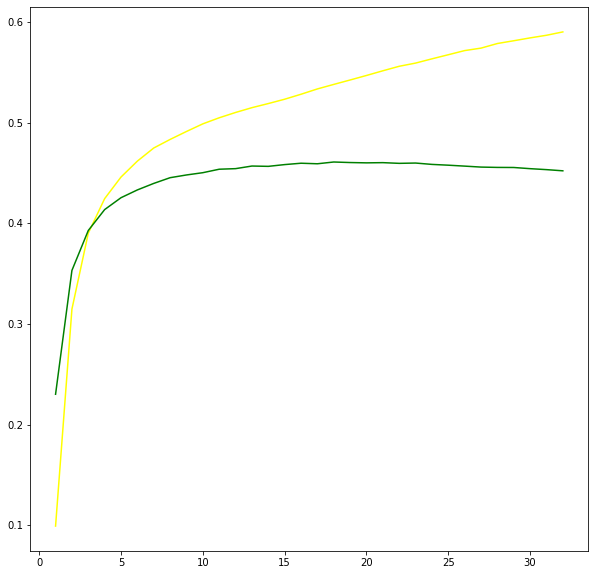

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1,len(acc)+1)
plt.figure(figsize = (10,10))
plt.plot(epochs,acc,color= 'yellow')
plt.plot(epochs,val_acc,color = 'green')

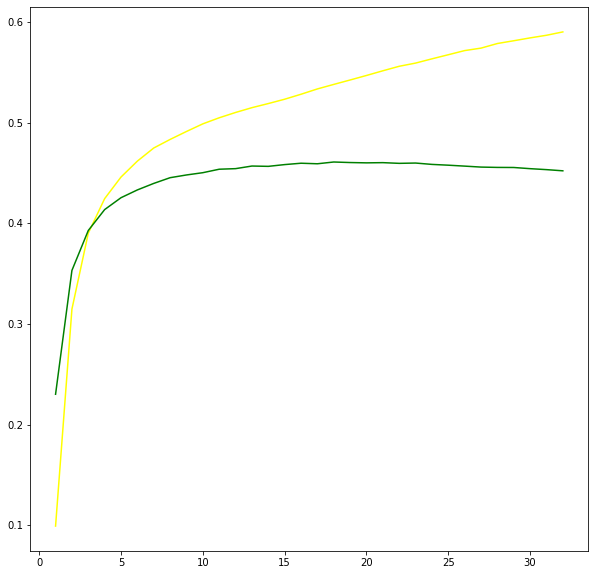

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)
plt.figure(figsize = (10,10))
plt.plot(epochs,acc,color= 'yellow')
plt.plot(epochs,val_acc,color = 'green')

In [18]:
model = load_model('dot_product_model.h5')
test_loss , test_acc = model.evaluate([test.user_id, test.book_id], test.rating)

196352/196352 [==============================] - 11s 57us/step


In [19]:
print(f"The loss on test set is {test_loss} and accuracy is {test_acc}")

The loss on test set is 1.037909746796592 and accuracy is 0.4525342285633087


In [20]:
## clearly the dot product model isn't the best model for our problem
## we will explore other several possible neural network architecures
concatenate_features = Concatenate()([book_vec, user_vec])

# adding  fully-connected-layers
fc1 = Dense(128, activation='relu')(concatenate_features)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1)(fc2)

# Create model and compile it
model2 = Model([user_input, book_input], out)
model2.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics = ['acc'])

In [21]:
history2 = model2.fit([train.user_id, train.book_id], train.rating,
                    validation_data = ([validate.user_id,validate.book_id],validate.rating),
                    epochs=32)

Train on 589053 samples, validate on 196351 samples
Epoch 1/32
589053/589053 [==============================] - 94s 159us/step - loss: 0.5512 - acc: 0.5636 - val_loss: 0.8596 - val_acc: 0.4487
Epoch 2/32
589053/589053 [==============================] - 92s 155us/step - loss: 0.5070 - acc: 0.5925 - val_loss: 0.8670 - val_acc: 0.4708
Epoch 3/32
589053/589053 [==============================] - 96s 163us/step - loss: 0.4892 - acc: 0.6059 - val_loss: 0.8596 - val_acc: 0.4673
Epoch 4/32
589053/589053 [==============================] - 105s 178us/step - loss: 0.4754 - acc: 0.6166 - val_loss: 0.8611 - val_acc: 0.4628
Epoch 5/32
589053/589053 [==============================] - 104s 177us/step - loss: 0.4634 - acc: 0.6254 - val_loss: 0.8533 - val_acc: 0.4657
Epoch 6/32
589053/589053 [==============================] - 94s 159us/step - loss: 0.4535 - acc: 0.6333 - val_loss: 0.8556 - val_acc: 0.4700
Epoch 7/32
589053/589053 [==============================] - 91s 154us/step - loss: 0.4444 - acc: 0.6

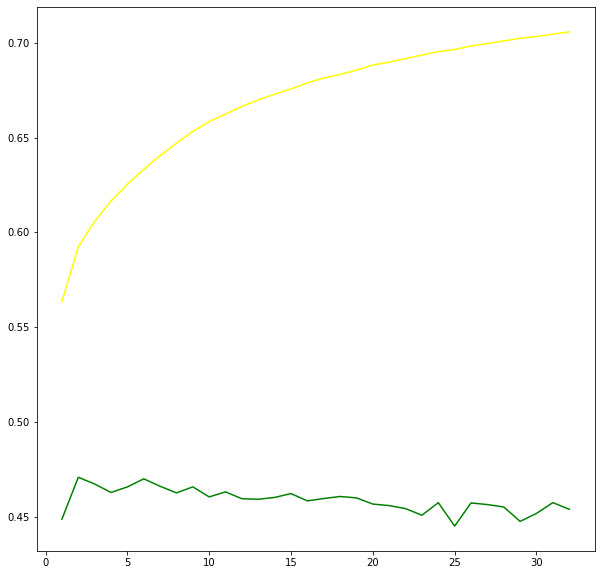

In [22]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
epochs = range(1,len(acc)+1)
plt.figure(figsize = (10,10))
plt.plot(epochs,acc,color= 'yellow')
plt.plot(epochs,val_acc,color = 'green')

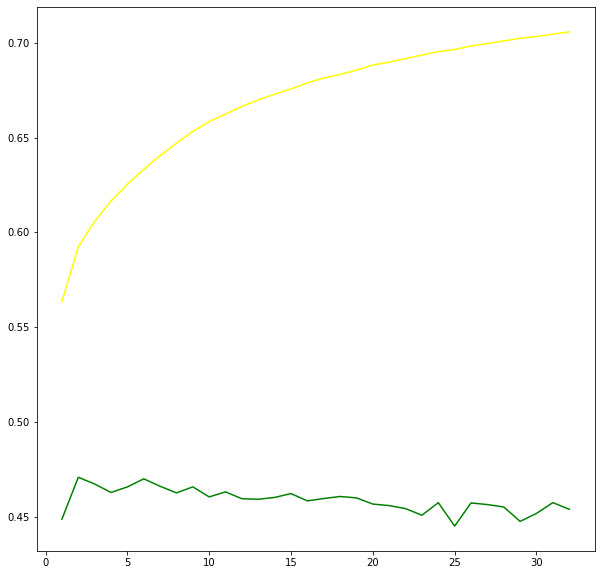

In [23]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1,len(acc)+1)
plt.figure(figsize = (10,10))
plt.plot(epochs,acc,color= 'yellow')
plt.plot(epochs,val_acc,color = 'green')

In [24]:
model2.save('nn1_model.h5')

In [25]:
model2 = load_model('nn1_model.h5')
test_loss , test_acc = model2.evaluate([test.user_id, test.book_id], test.rating)

196352/196352 [==============================] - 12s 63us/step


In [26]:
print(f"The loss on test set is {test_loss} and accuracy is {test_acc}")

The loss on test set is 0.9371471319498186 and accuracy is 0.454214870929718


In [27]:
## clearly the dot product model isn't the best model for our problem
## we will explore other several possible neural network architecures
concatenate_features = Concatenate()([book_vec, user_vec])

# adding  fully-connected-layers
fc1 = Dense(128, activation='relu')(concatenate_features)
d1 = Dropout(0.5)(fc1)
fc2 = Dense(32, activation='relu')(d1)
out = Dense(1)(fc2)

# Create model and compile it
model3 = Model([user_input, book_input], out)
model3.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics = ['acc'])

In [28]:
history3 = model3.fit([train.user_id, train.book_id], train.rating,
                    validation_data = ([validate.user_id,validate.book_id],validate.rating),
                    epochs=32)

Train on 589053 samples, validate on 196351 samples
Epoch 1/32
589053/589053 [==============================] - 99s 169us/step - loss: 0.5526 - acc: 0.5591 - val_loss: 1.2448 - val_acc: 0.2931
Epoch 2/32
589053/589053 [==============================] - 99s 168us/step - loss: 0.4635 - acc: 0.6129 - val_loss: 0.9762 - val_acc: 0.3512
Epoch 3/32
589053/589053 [==============================] - 99s 168us/step - loss: 0.4479 - acc: 0.6249 - val_loss: 1.0189 - val_acc: 0.3378
Epoch 4/32
589053/589053 [==============================] - 103s 175us/step - loss: 0.4396 - acc: 0.6325 - val_loss: 1.0315 - val_acc: 0.3339
Epoch 5/32
589053/589053 [==============================] - 104s 177us/step - loss: 0.4325 - acc: 0.6384 - val_loss: 0.9615 - val_acc: 0.3511
Epoch 6/32
589053/589053 [==============================] - 104s 176us/step - loss: 0.4272 - acc: 0.6429 - val_loss: 0.8948 - val_acc: 0.3696
Epoch 7/32
589053/589053 [==============================] - 103s 176us/step - loss: 0.4221 - acc: 0

In [29]:
model3.save('nn2_model.h5')

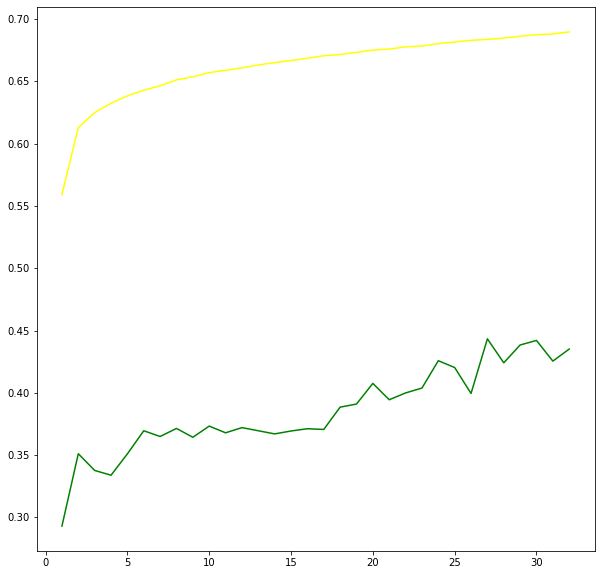

In [30]:
acc = history3.history['acc']
val_acc = history3.history['val_acc']
epochs = range(1,len(acc)+1)
plt.figure(figsize = (10,10))
plt.plot(epochs,acc,color= 'yellow')
plt.plot(epochs,val_acc,color = 'green')

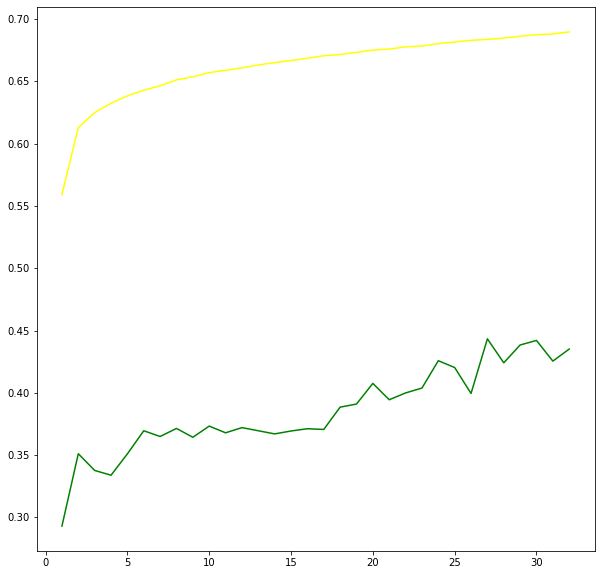

In [31]:
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1,len(acc)+1)
plt.figure(figsize = (10,10))
plt.plot(epochs,acc,color= 'yellow')
plt.plot(epochs,val_acc,color = 'green')

In [32]:
model3 = load_model('nn2_model.h5')
test_loss , test_acc = model3.evaluate([test.user_id, test.book_id], test.rating)

196352/196352 [==============================] - 13s 65us/step


In [33]:
print(f"The loss on test set is {test_loss} and accuracy is {test_acc}")

The loss on test set is 0.8582876167919443 and accuracy is 0.435427188873291
